In [798]:
# Importing initial packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("deep")
import matplotlib.pyplot as plt

# Setting the device to GPU for parallelization
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

mps


In [799]:
# Setting Hyperparameters
batch_size = 64
epochs = 15

## Data Loading, Cleaning, and Preprocessing

### Data Loading

In [800]:
# In my project folder I added a data folder with both files (found in repo README) but did not push (gitignore) due to size
movies = pd.read_csv('data/movies.csv')

ratings = pd.read_csv('data/ratings.csv')

#### Inspecting the data

In [801]:
print(f"""The shape of movies is: {movies.shape}
The shape of rating is: {ratings.shape}""")

print(f"""The columns of movies is: {movies.columns.to_list()}
The columns of rating is: {ratings.columns.to_list()}

* Notice that both df's have a movieId column, which will be useful for merging""")

The shape of movies is: (9742, 3)
The shape of rating is: (100836, 4)
The columns of movies is: ['movieId', 'title', 'genres']
The columns of rating is: ['userId', 'movieId', 'rating', 'timestamp']

* Notice that both df's have a movieId column, which will be useful for merging


In [802]:
# Creating encoders and decoders for our movie ids
movie_ids = list(movies.movieId)
moviesid_to_title = dict(zip(movies.movieId,movies.title))    # Decoder
movietitle_to_id = {j:i for i,j in moviesid_to_title.items()} # Encoder

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [826]:
ratings.head()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


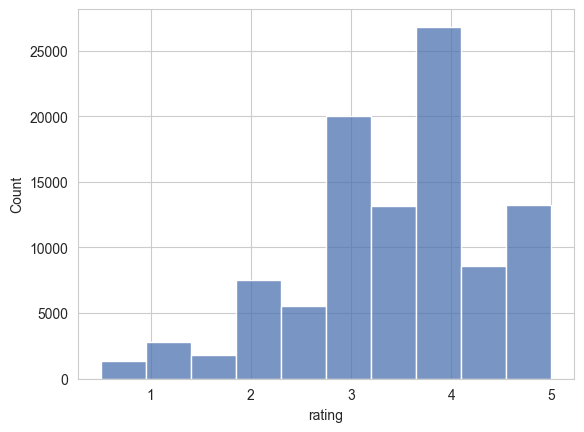

In [804]:
sns.histplot(ratings.rating, bins = 10)
plt.show()

As this is an already cleaned dataset, we can skip over to data preprocessing.

### Data Preprocessing

For this project we will first need to create a user-movie interaction matrix.

In [805]:
# Assume NAs are not watched by user, so rating of 0
user_rating_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [806]:
# Convert this from a pandas df to numpy array
user_rating_matrix_np = user_rating_matrix.values
print(f"Shape of the numpy matrix: {user_rating_matrix_np.shape}; represting {user_rating_matrix_np.shape[0]} users with {user_rating_matrix_np.shape[1]} movies.")

Shape of the numpy matrix: (610, 9724); represting 610 users with 9724 movies.


In [807]:
# Split into training and test split
train_data, test_data = train_test_split(user_rating_matrix_np, test_size=0.2, random_state=42)

In [808]:
# Convert to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

### Creating DataLoader

In [809]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data.nonzero(as_tuple=True) # Get the indices of non-zero elements
        self.ratings = data[self.data]          # Using non-zero indiced to extract those ratings

    def __len__ (self):
        return len(self.data[0])
    
    def __getitem__ (self, idx):
        user = self.data[0][idx]
        item = self.data[1][idx]
        rating = self.ratings[idx]
        
        return user, item, rating
    
train_dataset = RatingsDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

test_dataset = RatingsDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

print(f"Batch size: {batch_size}")
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")


Batch size: 64
Number of samples in train_dataset: 73177
Number of samples in test_dataset: 27659


## Model Development

### Defining Recommender model class

In [810]:
# Model definition
class Recommender(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 256)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(256, 128)                        # Second fc layer
        self.fc3 = nn.Linear(128, 16)                         # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(16, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(16)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x


# Defining model parameters (amount of users and movies) based on our data
num_users, num_items = user_rating_matrix_np.shape

# Initializing the model
model = Recommender(num_users, num_items)
model = model.to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=2.5e-5)

Now that we have created our model, and prepared the data for training, we can move onto model training!

## Model Training

In [823]:
def training_loop(epochs):
    model.train()
    loss_dict = {}
    for epoch in range(1, epochs+1):
        total_loss = 0
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            optimizer.zero_grad()
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print loss after every epoch
        epoch_loss = total_loss/len(train_loader)      # Get the average loss for this epoch
        loss_dict[epoch] = epoch_loss                  # Store this epoch, loss into a dict for graphing
        print(f"Epoch {epoch}, Loss: {epoch_loss}")    # Print the average loss for this epoch
    
    return loss_dict                                       # Just return the final loss 

# loss_dict = training_loop(epochs)

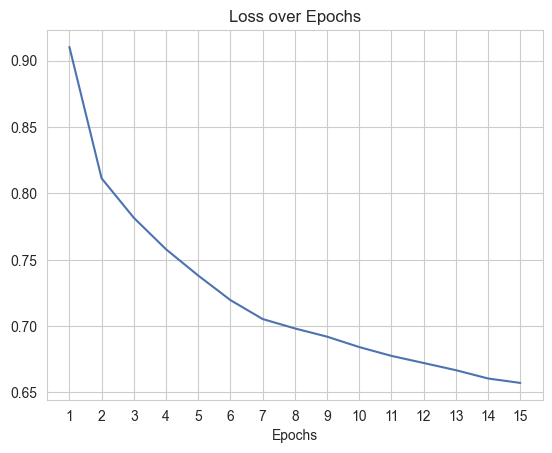

In [813]:
sns.lineplot(loss_dict)
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.xticks(range(1,epochs+1))
plt.show()


Noticing an elbow point around 5, so we will update epochs to 5 to mitigate overfitting.

In [814]:
# New epochs amount after analysis
epochs = 6
# Reinitialise the model
model = Recommender(num_users, num_items)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=2.5e-5)

# Retrain the model
training_loop(epochs)

Epoch 1, Loss: 0.9215271129839487
Epoch 2, Loss: 0.805275635285811
Epoch 3, Loss: 0.7795358488036619
Epoch 4, Loss: 0.7567991183197998
Epoch 5, Loss: 0.7390240919548314
Epoch 6, Loss: 0.7263010537864029


{1: 0.9215271129839487,
 2: 0.805275635285811,
 3: 0.7795358488036619,
 4: 0.7567991183197998,
 5: 0.7390240919548314,
 6: 0.7263010537864029}

## Model Evaluation

In [815]:
def validation_loop():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for user, item, rating in test_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            total_loss += loss.item()
        
    test_loss = total_loss / len(test_loader)   

    print(f"Test Loss: {test_loss}")
    return test_loss

validation_loop()

Test Loss: 0.9028074965311116


0.9028074965311116

We recieved a test loss much higher than our training loss. We overfit! We'll continue to tuning the model

## Hyperparameter Tuning

Here we'll test different 

## Checking the Model

In [824]:
def ratings_review(user_id, movie_ids):
    model.eval()                                 # Set model to evaluation mode
    user = torch.tensor([user_id] * len(movie_ids)).to(device)  # Ensure tensor is on the same device as the model
    movies = torch.tensor(movie_ids).to(device)  # Ensure tensor is on the same device as the model
    with torch.no_grad():
        predicted_ratings = model(user, movies).squeeze().tolist()

    return predicted_ratings

ratings_list = []
for id in ratings.userId.unique():
        recommended_movies = ratings_review(id, movie_ids)
        ratings_list.append(recommended_movies[0])

<Axes: >

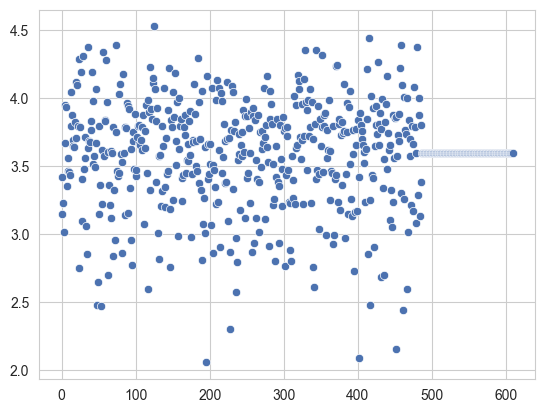

In [825]:
sns.scatterplot(ratings_list)

### Boxplots

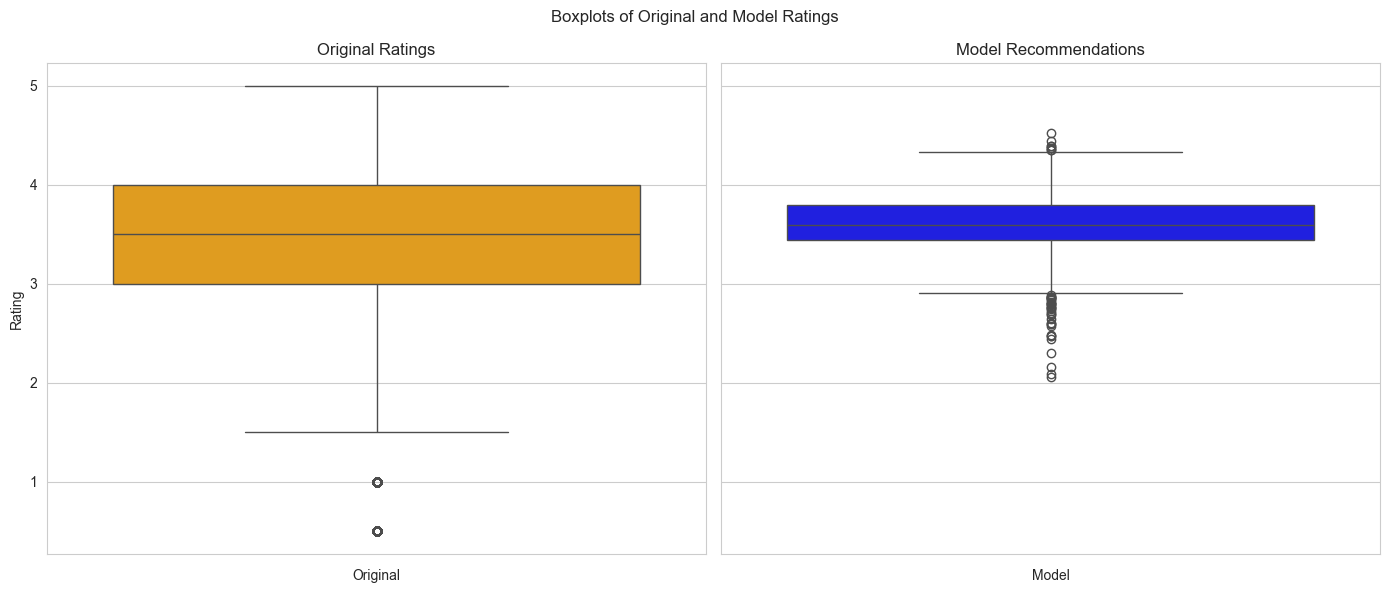

In [818]:
ratings_series = pd.Series(ratings_list)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original Data
sns.boxplot(y=ratings['rating'], ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Original')
axes[0].set_ylabel('Rating')

# Model Data
sns.boxplot(y=ratings_series, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Model')

# Adjust layout
plt.suptitle('Boxplots of Original and Model Ratings')
plt.tight_layout()
plt.show()

### Histograms

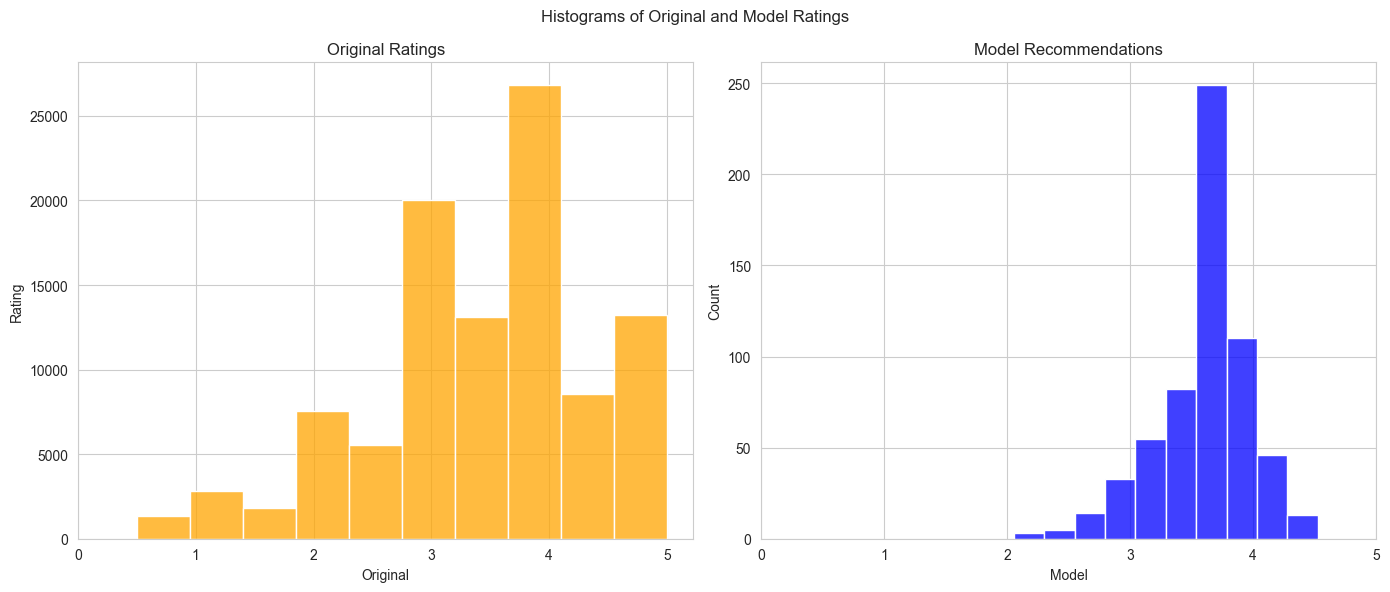

In [819]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
xticks = [0, 1, 2, 3, 4, 5]

bins = 10
# Original Data
sns.histplot(x=ratings['rating'], bins = bins, ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Original')
axes[0].set_ylabel('Rating')
axes[0].set_xticks(xticks)

# Model Data
sns.histplot(x=ratings_series, bins = bins, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Model')
axes[1].set_xticks(xticks)


# Adjust layout
plt.suptitle('Histograms of Original and Model Ratings')
plt.tight_layout()
plt.show()

In [820]:
ratings_series = pd.Series(ratings_list)
ratings_series.describe()

count    610.000000
mean       3.584557
std        0.371704
min        2.055391
25%        3.438779
50%        3.599113
75%        3.798155
max        4.525706
dtype: float64

In [821]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Using the Model for Recommendations

In [822]:
def recommend_movies(user_id, movie_ids, top_n=10):
    model.eval()                                 # Set model to evaluation mode
    user = torch.tensor([user_id] * len(movie_ids)).to(device)  # Ensure tensor is on the same device as the model
    movies = torch.tensor(movie_ids).to(device)  # Ensure tensor is on the same device as the model
    with torch.no_grad():
        predicted_ratings = model(user, movies).squeeze()
    top_movie_indices = predicted_ratings.argsort(descending=True)[:top_n]
    recommended_movie_ids = movies[top_movie_indices].tolist()
    recommended_ratings = predicted_ratings[top_movie_indices].tolist()
    recommendations = list(zip([user_id] * top_n, recommended_movie_ids, recommended_ratings))
    return recommendations

# Example usage for recommendations
recommended_movies = recommend_movies(5, movie_ids, top_n=1)


print(f"For User: {recommended_movies[0][0]}, \"{moviesid_to_title[recommended_movies[0][1]]}\" has an estimated rating of {recommended_movies[0][2]:.2f}")

For User: 5, "Miracle on 34th Street (1994)" has an estimated rating of 4.44
